In [87]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [88]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [89]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [24]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_csv(f'{target_column}/{city}.csv',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [25]:
for city, state, conties in cities:
    df0 = pd.read_csv(f'S000/{city}.csv')
    df1 = pd.read_csv(f'SE01/{city}.csv')
    df3 = pd.read_csv(f'SE03/{city}.csv')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_csv(f'income/{city}.csv', index=False)

# baseline

### unconstrain model, power law

In [90]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [91]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = (results.params[0],subData['distance'].mean())
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## linear f(d)

In [92]:
def unconstrained_bucked_linear_kpredict(test,target,k,binf):
    
    # linear interpolation to get f(d) value for each distance value
    # backfill to fill values for values in the fisrt and last half bins
    binfdf_interpolation = pd.DataFrame(binf).T
    binfdf_interpolation.columns = ['f(d)','distance']
    binfdf_interpolation['bin'] = binf.keys()
    binfdf_interpolation = pd.concat([test[['distance']].drop_duplicates(),binfdf_interpolation]).sort_values(by='distance')
    binfdf_interpolation = binfdf_interpolation.set_index('distance')
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)'].interpolate(method='index')
    binfdf_interpolation = binfdf_interpolation.reset_index()
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)inter'].fillna(method='backfill')
    binfdf_interpolation = binfdf_interpolation[['distance','f(d)inter']]
    binfdf_interpolation.columns = ['distance',target+'_f(d)inter']
    
    test = test.merge(binfdf_interpolation,on='distance')
    test[target+'k'] = k
#     test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'_f(d)inter']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [93]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

## find optimal bin

#### determined to use 40 bins from the figure above

In [94]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
#     thre = max(int(0.01*len(df)),2000)
    thre = int(rate*len(df))


    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre:
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)
            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [95]:


# 5-fold 
resultsfd40is = {}
resultsfd40os = {}

resultslfd40is = {}
resultslfd40os = {}

resultsBaselineis = {}
resultsBaselineos = {}
number = 2000
fdworsecounttemp = 0
rate = 0.002
bins = 40
for city,state, counties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),bins+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    binlist = []
    longestbin = []
    for binInd in sorted(df.bin.unique()):
        ODvolume = len(df.loc[df['bin']==binInd])
    #     print(ODvolume)
        if ODvolume > 200:
            binlist += [binInd]
        else:
            if len(binlist) > len(longestbin):
                longestbin = binlist
    #         print(binlist)
            binlist = []
    # when all bin statisfy 0.1%, longestbin will be empty    
    if len(binlist) > len(longestbin):
        selectedbin = binlist
    else:
        selectedbin = longestbin
    df = df.loc[df['bin'].isin(selectedbin)]
    
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
        # fd
    for target in ['S000']:
        print(target)

        fdmseis = 0
        fdmseos = 0
        lfdmseis = 0
        lfdmseos = 0
        blmseis = 0
        blmseos = 0
        for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
            traindf, testdf = df.iloc[train_index], df.iloc[test_index]
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            
            # linear interpolated f(d), include distance in formulation
            df_lfdis = unconstrained_bucked_linear_kpredict(traindf,target,k,binf)
            df_lfdos = unconstrained_bucked_linear_kpredict(testdf,target,k,binf)
            
            fdmseis += mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos += mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
            
            lfdmseis += mean_squared_error(df_lfdis[target+'flow'],df_lfdis[target+'pred'])
            lfdmseos += mean_squared_error(df_lfdos[target+'flow'],df_lfdos[target+'pred'])
        
            # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
        
            
        resultsfd40is[city] = resultsfd40is.get(city,[])+ [fdmseis/5]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ [fdmseos/5,]
        
        resultslfd40is[city] = resultslfd40is.get(city,[])+ [lfdmseis/5]
        resultslfd40os[city] = resultslfd40os.get(city,[])+ [lfdmseos/5]
        
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + [blmseis/5]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + [blmseos/5]
        print('---------------------------------------')
        print('os',round(blmseos/5,2),round(fdmseos/5,2),round(lfdmseos/5,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1


New York City
S000
---------------------------------------
os 3.35 3.35 3.34
Los Angeles
S000
---------------------------------------
os 9.6 9.68 9.54
Chicago
S000
---------------------------------------
os 17.81 17.44 16.96
Houston
S000
---------------------------------------
os 41.85 42.55 41.84
Boston
S000
---------------------------------------
os 49.88 49.74 49.62
Phoenix
S000
---------------------------------------
os 18.31 18.23 18.18
Philadelphia
S000
---------------------------------------
os 19.68 20.09 19.91
San Antonio
S000
---------------------------------------
os 41.36 42.0 41.82
San Diego
S000
---------------------------------------
os 49.02 48.21 47.79
Dallas
S000
---------------------------------------
os 26.97 27.45 26.99
San Jose
S000
---------------------------------------
os 50.63 51.42 50.96
Austin
S000
---------------------------------------
os 111.95 114.1 113.81


In [145]:
msedffd = pd.DataFrame(resultsfd40is).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedflfd = pd.DataFrame(resultslfd40is).T
msedflfd.columns = [i+'lfd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineis).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,3.347891,3.333463,0.340841,0.338449,1.476147,1.467858
Los Angeles,9.568779,9.486824,1.375833,1.345650,2.516680,2.457623
Chicago,17.785332,16.710155,1.420152,1.394819,7.472493,6.506775
Houston,41.789413,40.993248,1.928494,1.893636,16.651707,16.210427
Boston,49.829721,49.179530,3.616453,3.592496,18.150362,17.805999
Phoenix,18.296667,18.069868,1.486335,1.472044,5.790267,5.687677
Philadelphia,19.106924,17.496404,1.324118,1.305585,7.832003,6.825792
San Antonio,41.284058,40.706087,3.160716,3.146527,14.021826,13.540506
San Diego,48.895218,46.312527,3.368229,3.324754,16.644409,15.326953
Dallas,26.926640,26.345387,1.556247,1.546484,10.579711,10.241209


In [146]:
msedffd = pd.DataFrame(resultsfd40os).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedflfd = pd.DataFrame(resultslfd40os).T
msedflfd.columns = [i+'lfd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineos).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedflfd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedflfd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,S000lfd,SE01bl,SE01fd,SE01lfd,SE03bl,SE03fd,SE03lfd
New York City,3.348758,3.347724,3.398224,0.341817,0.343781,0.350415,1.476441,1.479180,1.481053
Los Angeles,9.596692,9.676639,18.984801,1.378095,1.363051,3.043274,2.528754,2.581830,4.063090
Chicago,17.810498,17.435494,20.563643,1.422101,1.481652,1.992836,7.485412,6.958032,7.127336
Houston,41.851408,42.552248,50.984064,1.928883,1.910010,2.471351,16.694846,17.399429,19.397235
Boston,49.880829,49.736734,59.720782,3.619422,3.625111,4.568461,18.181325,18.163153,20.218624
Phoenix,18.305931,18.233161,23.477140,1.487749,1.493335,1.902196,5.793275,5.748640,6.730805
Philadelphia,19.680797,20.086923,20.333738,1.324960,1.329992,1.388008,8.453149,8.640315,8.621056
San Antonio,41.362357,41.999323,44.398593,3.165531,3.202999,3.420215,14.052447,14.236662,14.612941
San Diego,49.022843,48.209408,61.063674,3.376327,3.459940,5.070809,16.753249,16.569690,18.008327
Dallas,26.974235,27.450179,29.482658,1.558471,1.573294,1.701009,10.628469,11.045515,11.552562


# train on the whole dataset to get curves


In [96]:


resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
# number = 2000
fdworsecounttemp = 0
rate = 0.033
bins = 30
for city,state, counties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),bins+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    binlist = []
    longestbin = []
    for binInd in sorted(df.bin.unique()):
        ODvolume = len(df.loc[df['bin']==binInd])
    #     print(ODvolume)
        if ODvolume > 200:
            binlist += [binInd]
        else:
            if len(binlist) > len(longestbin):
                longestbin = binlist
    #         print(binlist)
            binlist = []
    # when all bin statisfy 0.1%, longestbin will be empty    
    if len(binlist) > len(longestbin):
        selectedbin = binlist
    else:
        selectedbin = longestbin
    df = df.loc[df['bin'].isin(selectedbin)]
    
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
        binf,k = unconstrained_bucked_constant_kfit(df, target)
        print(target)
        df_fdis = unconstrained_bucked_constant_kpredict(df,target,k,binf)
        binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
        resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]


New York City
SE01
SE03
S000
Los Angeles
SE01
SE03
S000
Chicago
SE01
SE03
S000
Houston
SE01
SE03
S000
Boston
SE01
SE03
S000
Phoenix
SE01
SE03
S000
Philadelphia
SE01
SE03
S000
San Antonio
SE01
SE03
S000
San Diego
SE01
SE03
S000
Dallas
SE01
SE03
S000
San Jose
SE01
SE03
S000
Austin
SE01
SE03
S000


In [97]:
# convert bins back to distance
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income1[bins],income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income3[bins],income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income0[bins],income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

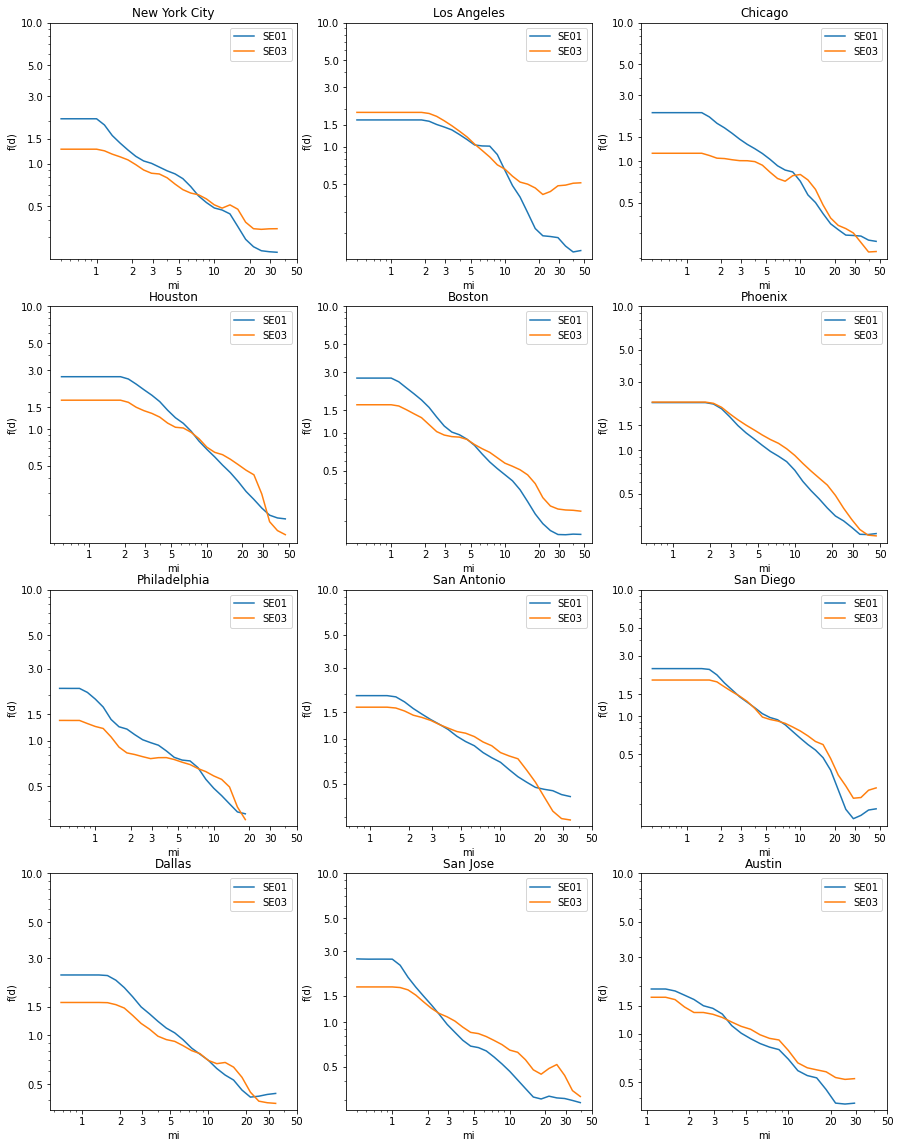

In [100]:
# 0.2% / 2000

fig,ax = plt.subplots(4,3,figsize=(15,20))
i= 0
for city,state, counties in cities:
#     if city in ['Chicago','Phoenix','Houston','San Antonio','Austin', 'San Jose']:
#         pass
#     else:
    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df['bin+1'] = df['bin'].shift(1)
    df['bin+1'].fillna(df['bin'][0],inplace=True)
    df['fd+1'] = df['fd'].shift(1)
    df['fd+1'].fillna(df['fd'][0],inplace=True)
    df['fdsmooth'] = (df['fd']+df['fd+1'])/2
    df['binsmooth'] = (df['bin']+df['bin+1'])/2
    df = df.sort_values(by='bin')
    ax[i//3,i%3].plot(df['binsmooth'],df['fdsmooth'],label='SE03')

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].set_ylabel('f(d)')
    ax[i//3,i%3].set_xlabel('mi')
    i += 1

# plt.savefig('img/curve.png')

## Compute correlation between f(d) delta and distance

In [135]:
for city,state, counties in cities:
    df1 = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df3 = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    joined = df1.join(df3, lsuffix='SE01', rsuffix='SE03')
    joined['diff'] = joined.fdSE01 - joined.fdSE03
    joined['distance'] = joined.binSE01
    correlation = joined['distance'].corr(joined['diff'])
    print(f"{city}: {correlation}")

New York City: -0.6579451737254872
Los Angeles: -0.37917290424062783
Chicago: -0.62925307412143
Houston: -0.6605574076919117
Boston: -0.5818566238748446
Phoenix: 0.19585710513972684
Philadelphia: -0.7005389055079367
San Antonio: -0.18814704818556616
San Diego: -0.6032036428056923
Dallas: -0.6547545622751236
San Jose: -0.45162504343108617
Austin: -0.672207185639764
